# Data owner 1
Controls left half of images

In [1]:
from uuid import uuid4

import torch
from torchvision import datasets
from torchvision import transforms

import syft as sy

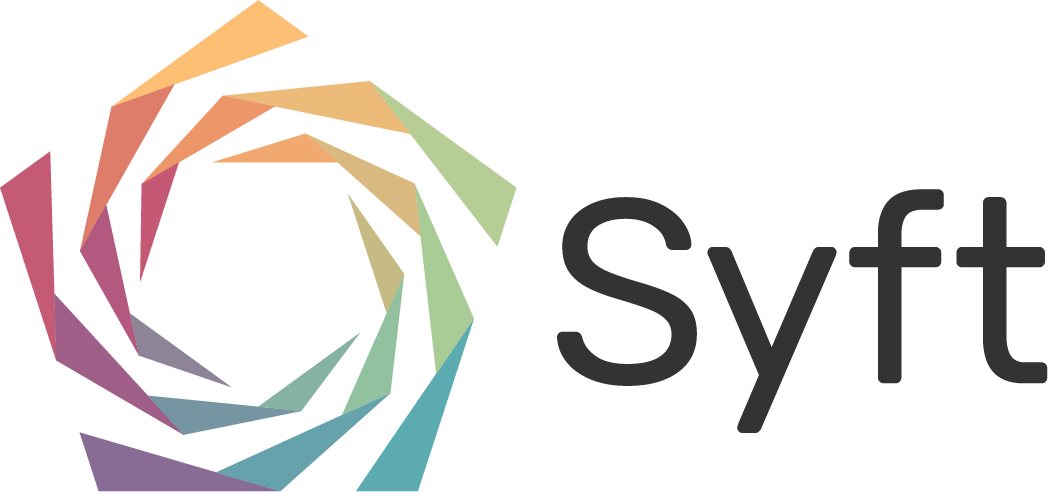

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.join_duet(loopback=True)

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!



In [2]:
duet = sy.duet(loopback=True)

---

## Load data

We use a utility function to split the MNIST dataset in two: left and right halves.
Data owner 1 owns the left halves of the images.
In practice, DO1 would already have this dataset, so splitting would not be necessary.

In [10]:
def split_data(dataset, worker_list=None, n_workers=2):

    if worker_list is None:
        worker_list = list(range(0, n_workers))
            
    #counter to create the index of different data samples
    idx = 0 
    
    #dictionary to accomodate the split data
    dic_single_datasets = {}
    for worker in worker_list: 
        """
        Each value is a list of three elements, to accomodate, in order: 
        - data examples (as tensors)
        - label
        - index 
        """
        dic_single_datasets[worker] = [] 

    """
    Loop through the dataset to split the data and labels vertically across workers. 
    Splitting method from @abbas5253: https://github.com/abbas5253/SplitNN-for-Vertically-Partitioned-Data/blob/master/distribute_data.py
    """
    label_list = []
    index_list = []
    index_list_UUID = []
    for tensor, label in dataset:
        height = tensor.shape[-1]//len(worker_list)
        i = 0
        uuid_idx = uuid4()
        for worker in worker_list[:-1]: 
            dic_single_datasets[worker].append(tensor[:, :, height * i : height * (i + 1)])
            i += 1
            
        #add the value of the last worker / split
        dic_single_datasets[worker_list[-1]].append(tensor[:, :, height * (i) : ])
        label_list.append(torch.Tensor([label]))
        index_list_UUID.append(uuid_idx)
        index_list.append(torch.Tensor([idx]))
        
        idx += 1
        
    return dic_single_datasets, label_list, index_list, index_list_UUID

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
valset = datasets.MNIST('mnist', download=True, train=False, transform=transform)

In [12]:
img, _, _, _ = split_data(trainset)
img = torch.cat(img[0][:25_000])  # get the first split of the data
img_rshp = img.view(img.shape[0], -1)
print(img_rshp.shape)

torch.Size([10000, 392])


In [13]:
val_img, _, _, _ = split_data(valset)
val_img = torch.cat(val_img[0][:2_000])
val_img_rshp = val_img.view(val_img.shape[0], -1)
print(val_img_rshp.shape)

torch.Size([10000, 392])


---

## Send to the data scientist

DS can now use pointers to the data to train a model.
The DS **cannot** access the raw data.

In [14]:
img_rshp.send(duet, searchable=True, tags=["flatten"], description="flattened")
val_img_rshp.send(duet, searchable=True, tags=["flatten_val"], description="flattened validation data")

In [15]:
duet.requests.add_handler(action="accept", tags=[""])

/home/tom/Documents/OM/PySyft/src/syft/lib/torch/uppercase_tensor.py:45: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(self.value, "grad", None)
/home/tom/anaconda3/envs/pyv_duet/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
[2021-02-24T21:10:02.287835+0000][CRITICAL][logger] <class 'syft.core.store.store_m